The notebook is based on this: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb

# 1. Load dataset

In [1]:
from datasets import load_dataset 

dataset = load_dataset("nielsr/cord-layoutlmv3")

c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset cord-layoutlmv3 (C:/Users/Habram/.cache/huggingface/datasets/nielsr___cord-layoutlmv3/cord/1.0.0/581083d58bb5c35fdcfed4f7b36f9a8bf23acfd28e974edc7b8157c972720203)
100%|██████████| 3/3 [00:00<00:00,  9.04it/s]


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image'],
        num_rows: 100
    })
})

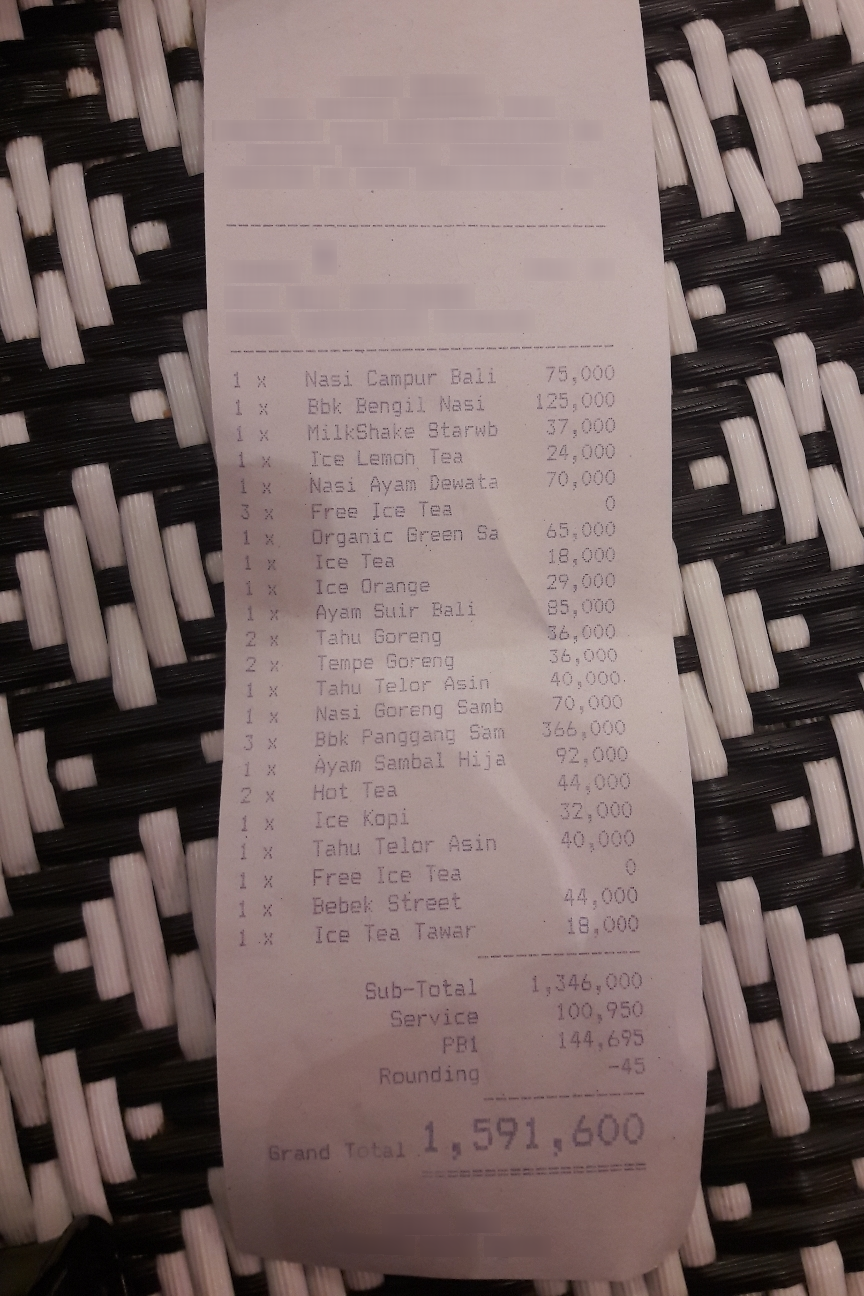

In [3]:
example = dataset["train"][0]
example["image"]

In [4]:
words, boxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '1', 'Nasi', 'Campur', 'Bali', '75,000', '1', 'Bbk', 'Bengil', 'Nasi', '125,000', '1', 'MilkShake', 'Starwb', '37,000', '1', 'Ice', 'Lemon', 'Tea', '24,000', '1', 'Nasi', 'Ayam', 'Dewata', '70,000', '3', 'Free', 'Ice', 'Tea', '0', '1', 'Organic', 'Green', 'Sa', '65,000', '1', 'Ice', 'Tea', '18,000', '1', 'Ice', 'Orange', '29,000', '1', 'Ayam', 'Suir', 'Bali', '85,000', '2', 'Tahu', 'Goreng', '36,000', '2', 'Tempe', 'Goreng', '36,000', '1', 'Tahu', 'Telor', 'Asin', '40,000.', '1', 'Nasi', 'Goreng', 'Samb', '70,000', '3', 'Bbk', 'Panggang', 'Sam', '366,000', '1', 'Ayam', 'Sambal', 'Hija', '92,000', '2', 'Hot', 'Tea', '44,000', '1', 'Ice', 'Kopi', '32,000', '1', 'Tahu', 'Telor', 'Asin', '40,000', '1', 'Free', 'Ice', 'Tea', '0', '1', 'Bebek', 'Street', '44,000', '1', 'Ice', 'Tea', 'Tawar', '18,000', 'Sub-Total', '1,346,000', 'Service', '100,950', 'PB1', '144,695', 'Rounding', '-45

# 2. Prepare dataset

In [5]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [6]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}

In [7]:
print(label_list)
print(id2label)

['O', 'B-MENU.NM', 'B-MENU.NUM', 'B-MENU.UNITPRICE', 'B-MENU.CNT', 'B-MENU.DISCOUNTPRICE', 'B-MENU.PRICE', 'B-MENU.ITEMSUBTOTAL', 'B-MENU.VATYN', 'B-MENU.ETC', 'B-MENU.SUB_NM', 'B-MENU.SUB_UNITPRICE', 'B-MENU.SUB_CNT', 'B-MENU.SUB_PRICE', 'B-MENU.SUB_ETC', 'B-VOID_MENU.NM', 'B-VOID_MENU.PRICE', 'B-SUB_TOTAL.SUBTOTAL_PRICE', 'B-SUB_TOTAL.DISCOUNT_PRICE', 'B-SUB_TOTAL.SERVICE_PRICE', 'B-SUB_TOTAL.OTHERSVC_PRICE', 'B-SUB_TOTAL.TAX_PRICE', 'B-SUB_TOTAL.ETC', 'B-TOTAL.TOTAL_PRICE', 'B-TOTAL.TOTAL_ETC', 'B-TOTAL.CASHPRICE', 'B-TOTAL.CHANGEPRICE', 'B-TOTAL.CREDITCARDPRICE', 'B-TOTAL.EMONEYPRICE', 'B-TOTAL.MENUTYPE_CNT', 'B-TOTAL.MENUQTY_CNT', 'I-MENU.NM', 'I-MENU.NUM', 'I-MENU.UNITPRICE', 'I-MENU.CNT', 'I-MENU.DISCOUNTPRICE', 'I-MENU.PRICE', 'I-MENU.ITEMSUBTOTAL', 'I-MENU.VATYN', 'I-MENU.ETC', 'I-MENU.SUB_NM', 'I-MENU.SUB_UNITPRICE', 'I-MENU.SUB_CNT', 'I-MENU.SUB_PRICE', 'I-MENU.SUB_ETC', 'I-VOID_MENU.NM', 'I-VOID_MENU.PRICE', 'I-SUB_TOTAL.SUBTOTAL_PRICE', 'I-SUB_TOTAL.DISCOUNT_PRICE', 'I-SUB

In [8]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [15]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
valid_dataset = dataset["validation"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
test_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Loading cached processed dataset at C:\Users\Habram\.cache\huggingface\datasets\nielsr___cord-layoutlmv3\cord\1.0.0\581083d58bb5c35fdcfed4f7b36f9a8bf23acfd28e974edc7b8157c972720203\cache-63f598908744ccf6.arrow


In [16]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 800
})

In [17]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> x x x x x x x x x x x x x x x x x x x x x x 1 Nasi Campur Bali 75,000 1 Bbk Bengil Nasi 125,000 1 MilkShake Starwb 37,000 1 Ice Lemon Tea 24,000 1 Nasi Ayam Dewata 70,000 3 Free Ice Tea 0 1 Organic Green Sa 65,000 1 Ice Tea 18,000 1 Ice Orange 29,000 1 Ayam Suir Bali 85,000 2 Tahu Goreng 36,000 2 Tempe Goreng 36,000 1 Tahu Telor Asin 40,000. 1 Nasi Goreng Samb 70,000 3 Bbk Panggang Sam 366,000 1 Ayam Sambal Hija 92,000 2 Hot Tea 44,000 1 Ice Kopi 32,000 1 Tahu Telor Asin 40,000 1 Free Ice Tea 0 1 Bebek Street 44,000 1 Ice Tea Tawar 18,000 Sub-Total 1,346,000 Service 100,950 PB1 144,695 Rounding -45 Grand Total 1,591,600</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [18]:
train_dataset.set_format("torch")

In [19]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [20]:
valid_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 100
})

In [25]:
processor.tokenizer.decode(valid_dataset[0]["input_ids"])

'<s> 1 REAL GANACHE 16,500 1 EGG TART 13,000 1 PIZZA TOAST 16,000 TOTAL 45,500 CASH 50,000 CHANGE 4,500</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [22]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 x 4
 1 4
 N 1
asi -100
 Camp 31
ur -100
 B 31
ali -100
 75 6
, -100
000 -100
 1 4
 B 1
b -100
k -100
 Beng 31
il -100
 N 31
asi -100
 125 6
, -100
000 -100
 1 4
 Milk 1
Sh -100
ake -100
 Star 31
wb -100
 37 6
, -100
000 -100
 1 4
 Ice 1
 Lemon 31
 Tea 31
 24 6
, -100
000 -100
 1 4
 N 1
asi -100
 Ay 31
am -100
 Dew 31
ata -100
 70 6
, -100
000 -100
 3 4
 Free 1
 Ice 31
 Tea 31
 0 6
 1 4
 Organic 1
 Green 31
 Sa 31
 65 6
, -100
000 -100
 1 4
 Ice 1
 Tea 31
 18 6
, -100
000 -100
 1 4
 Ice 1
 Orange 31
 29 6
, -100
000 -100
 1 4
 Ay 1
am -100
 Su 31
ir -100
 B 31
ali -100
 85 6
, -100
000 -100
 2 4
 T 1
ahu -100
 Gore 31
ng -100
 36 6
, -100
000 -100
 2 4
 Tem 1
pe -100
 Gore 31
ng -100
 36 6
, -100
000 -100
 1 4
 T 1
ahu -100
 Tel 31
or -100
 As 31
in -100
 40 6
, -100
000 -100
. -100
 1 4
 N 1
asi -100
 Gore 31
ng -100
 Sam 31
b -100
 70 6
, -100
000 -100
 3 4
 B 1
b -100
k 

In [24]:
test_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 100
})

In [26]:
processor.tokenizer.decode(test_dataset[0]["input_ids"])

'<s> TAX 5.455 TOTAL 60.000 (Qty 2.00 EDC CIMB NIAGA No: xx7730 60.000 901016 -TICKET CP 2 60.000 60.000 Subtotal 60.000 TOTAL DISC $ -60.000</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

# 3. Define metrics

In [27]:
from datasets import load_metric

metric = load_metric("seqeval")

C:\Users\Habram\AppData\Local\Temp\ipykernel_23640\3097260500.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [28]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }
     

# 4. Define the model

In [29]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Define TrainingArguments + Trainer

In [30]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [31]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

# 6. Train the model

In [32]:
trainer.train()

c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 10%|█         | 100/1000 [21:12<3:09:25, 12.63s/it]c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                    
 1

{'eval_loss': 2.100705146789551, 'eval_precision': 0.5398110661268556, 'eval_recall': 0.5988023952095808, 'eval_f1': 0.5677785663591198, 'eval_accuracy': 0.5814940577249575, 'eval_runtime': 269.8948, 'eval_samples_per_second': 0.371, 'eval_steps_per_second': 0.185, 'epoch': 0.25}


                                                     
 20%|██        | 200/1000 [51:11<2:47:27, 12.56s/it]

{'eval_loss': 1.4799978733062744, 'eval_precision': 0.5404551201011378, 'eval_recall': 0.6399700598802395, 'eval_f1': 0.5860178204249485, 'eval_accuracy': 0.6761460101867572, 'eval_runtime': 269.6446, 'eval_samples_per_second': 0.371, 'eval_steps_per_second': 0.185, 'epoch': 0.5}


                                                      
 30%|███       | 300/1000 [1:17:22<2:34:27, 13.24s/it]

{'eval_loss': 1.1851263046264648, 'eval_precision': 0.6330698287220027, 'eval_recall': 0.719311377245509, 'eval_f1': 0.6734407848633497, 'eval_accuracy': 0.7389643463497453, 'eval_runtime': 288.2288, 'eval_samples_per_second': 0.347, 'eval_steps_per_second': 0.173, 'epoch': 0.75}


                                                       
 40%|████      | 400/1000 [1:42:52<2:05:16, 12.53s/it]

{'eval_loss': 0.9893913269042969, 'eval_precision': 0.7185338865836791, 'eval_recall': 0.7776946107784432, 'eval_f1': 0.7469446441409059, 'eval_accuracy': 0.7873514431239389, 'eval_runtime': 268.5655, 'eval_samples_per_second': 0.372, 'eval_steps_per_second': 0.186, 'epoch': 1.0}


 50%|█████     | 500/1000 [2:03:47<1:44:26, 12.53s/it] 

{'loss': 1.703, 'learning_rate': 5e-06, 'epoch': 1.25}


                                                      
 50%|█████     | 500/1000 [2:08:15<1:44:26, 12.53s/it]

{'eval_loss': 0.8700202703475952, 'eval_precision': 0.7853553481694185, 'eval_recall': 0.8188622754491018, 'eval_f1': 0.8017588860388422, 'eval_accuracy': 0.8200339558573854, 'eval_runtime': 268.1818, 'eval_samples_per_second': 0.373, 'eval_steps_per_second': 0.186, 'epoch': 1.25}


c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
 60%|██████    | 600/1000 [2:29:12<1:23:52, 12.58s/it] c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                      
 60%|██████    | 600/1000 [2:33:41<1:23:52, 12.58s/it]

{'eval_loss': 0.7783035039901733, 'eval_precision': 0.8116363636363636, 'eval_recall': 0.8353293413173652, 'eval_f1': 0.8233124308373293, 'eval_accuracy': 0.8310696095076401, 'eval_runtime': 268.1667, 'eval_samples_per_second': 0.373, 'eval_steps_per_second': 0.186, 'epoch': 1.5}


                                                       
 70%|███████   | 700/1000 [2:59:03<1:02:53, 12.58s/it]

{'eval_loss': 0.7172409296035767, 'eval_precision': 0.815597667638484, 'eval_recall': 0.8375748502994012, 'eval_f1': 0.8264401772525849, 'eval_accuracy': 0.83446519524618, 'eval_runtime': 267.3805, 'eval_samples_per_second': 0.374, 'eval_steps_per_second': 0.187, 'epoch': 1.75}


                                                      
 80%|████████  | 800/1000 [3:24:25<41:59, 12.60s/it]

{'eval_loss': 0.6853630542755127, 'eval_precision': 0.8264705882352941, 'eval_recall': 0.8413173652694611, 'eval_f1': 0.8338278931750741, 'eval_accuracy': 0.8365874363327674, 'eval_runtime': 267.6051, 'eval_samples_per_second': 0.374, 'eval_steps_per_second': 0.187, 'epoch': 2.0}


                                                      
 90%|█████████ | 900/1000 [3:49:43<20:46, 12.47s/it]

{'eval_loss': 0.6623630523681641, 'eval_precision': 0.8268525311812179, 'eval_recall': 0.843562874251497, 'eval_f1': 0.8351241200444609, 'eval_accuracy': 0.8404074702886248, 'eval_runtime': 266.5911, 'eval_samples_per_second': 0.375, 'eval_steps_per_second': 0.188, 'epoch': 2.25}


100%|██████████| 1000/1000 [4:10:31<00:00, 12.46s/it] 

{'loss': 0.7714, 'learning_rate': 0.0, 'epoch': 2.5}


                                                     
100%|██████████| 1000/1000 [4:14:58<00:00, 12.46s/it]

{'eval_loss': 0.6497805714607239, 'eval_precision': 0.8305209097578871, 'eval_recall': 0.8473053892215568, 'eval_f1': 0.838829195998518, 'eval_accuracy': 0.8433786078098472, 'eval_runtime': 266.5788, 'eval_samples_per_second': 0.375, 'eval_steps_per_second': 0.188, 'epoch': 2.5}


100%|██████████| 1000/1000 [4:15:00<00:00, 15.30s/it]

{'train_runtime': 15300.8922, 'train_samples_per_second': 0.131, 'train_steps_per_second': 0.065, 'train_loss': 1.23718115234375, 'epoch': 2.5}


TrainOutput(global_step=1000, training_loss=1.23718115234375, metrics={'train_runtime': 15300.8922, 'train_samples_per_second': 0.131, 'train_steps_per_second': 0.065, 'train_loss': 1.23718115234375, 'epoch': 2.5})

# 7. Evaluate the model

In [33]:
trainer.evaluate()

c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 50/50 [04:34<00:00,  5.48s/it]c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 50/50 [04:34<00:00,  5.49s/it]


{'eval_loss': 0.6497805714607239,
 'eval_precision': 0.8305209097578871,
 'eval_recall': 0.8473053892215568,
 'eval_f1': 0.838829195998518,
 'eval_accuracy': 0.8433786078098472,
 'eval_runtime': 280.0661,
 'eval_samples_per_second': 0.357,
 'eval_steps_per_second': 0.179,
 'epoch': 2.5}

# 8. Inference

In [34]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("test/checkpoint-1000")

In [57]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image'])


In [58]:
image = example["image"]
words = example["words"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 61])
attention_mask torch.Size([1, 61])
bbox torch.Size([1, 61, 4])
labels torch.Size([1, 61])
pixel_values torch.Size([1, 3, 224, 224])


In [59]:
with torch.no_grad():
  outputs = model(**encoding)

c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [60]:
logits = outputs.logits
logits.shape

torch.Size([1, 61, 61])

In [61]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[31, 21, 51, 51, 51, 51, 23, 53, 53, 53, 30, 60, 60, 60, 60, 60, 1, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 51, 51, 51, 51, 51, 4, 4, 31, 1, 1, 31, 31, 31, 4, 3, 3, 3, 6, 6, 6, 17, 47, 47, 47, 47, 23, 47, 47, 47, 47, 47, 47, 47, 31]


In [62]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 21, -100, 51, -100, -100, 23, 53, -100, -100, 30, -100, -100, 60, -100, -100, 27, -100, 57, -100, -100, 57, -100, -100, 57, -100, 57, -100, -100, 57, -100, -100, 2, -100, -100, 1, -100, -100, -100, 31, 4, 6, -100, -100, 7, -100, -100, 17, -100, 47, -100, -100, 18, 48, -100, 48, 48, -100, -100, -100, -100]


In [63]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [64]:
true_labels

['B-SUB_TOTAL.TAX_PRICE',
 'I-SUB_TOTAL.TAX_PRICE',
 'B-TOTAL.TOTAL_PRICE',
 'I-TOTAL.TOTAL_PRICE',
 'B-TOTAL.MENUQTY_CNT',
 'I-TOTAL.MENUQTY_CNT',
 'B-TOTAL.CREDITCARDPRICE',
 'I-TOTAL.CREDITCARDPRICE',
 'I-TOTAL.CREDITCARDPRICE',
 'I-TOTAL.CREDITCARDPRICE',
 'I-TOTAL.CREDITCARDPRICE',
 'I-TOTAL.CREDITCARDPRICE',
 'B-MENU.NUM',
 'B-MENU.NM',
 'I-MENU.NM',
 'B-MENU.CNT',
 'B-MENU.PRICE',
 'B-MENU.ITEMSUBTOTAL',
 'B-SUB_TOTAL.SUBTOTAL_PRICE',
 'I-SUB_TOTAL.SUBTOTAL_PRICE',
 'B-SUB_TOTAL.DISCOUNT_PRICE',
 'I-SUB_TOTAL.DISCOUNT_PRICE',
 'I-SUB_TOTAL.DISCOUNT_PRICE',
 'I-SUB_TOTAL.DISCOUNT_PRICE']

In [71]:
label2color = {'sub_total.tax_price'      :'blue',
               'total.total_price'        :'green',
               'total.menuqty_cnt'        :'orange',
               'total.creditcardprice'    :'violet',
               'total.cashprice'          :'darkorange',
               'total.changeprice'        :'sandybrown',
               'menu'                     :'yellow',
               'menu.num'                 :'pink',
               'menu.nm'                  :'blueviolet',
               'menu.cnt'                 :'salmon',
               'menu.price'               :'peru',
               'menu.unitprice'           :'darkgreen',
               'menu.itemsubtotal'        :'tan',
               'sub_total.subtotal_price' :'brown',
               'sub_total.discount_price' :'cyan'}

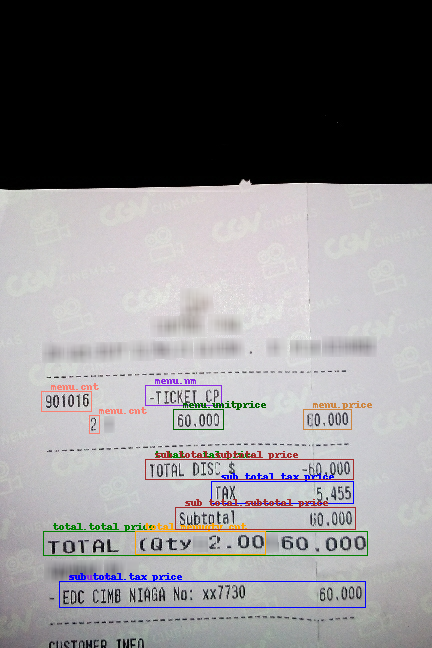

In [65]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

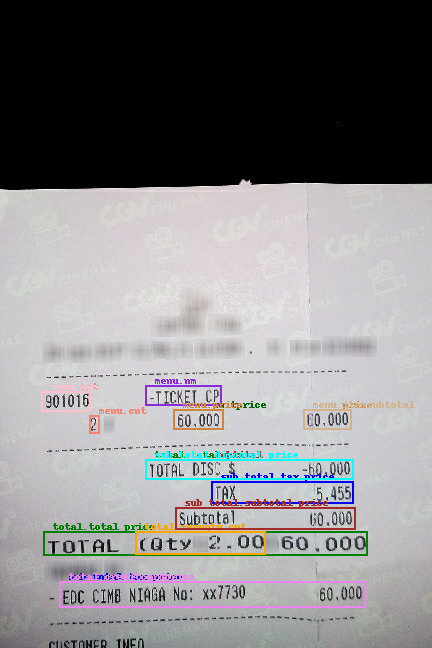

In [49]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

# 9. Show another example

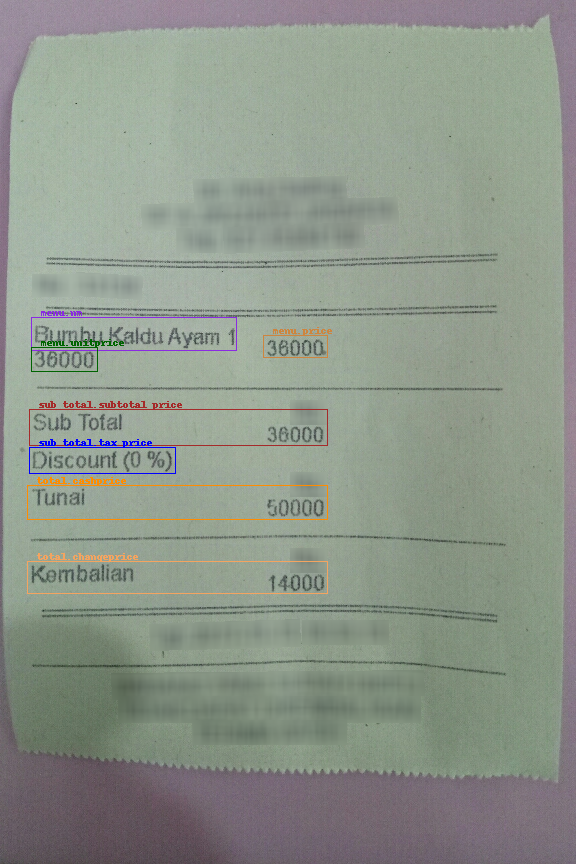

In [84]:
example = dataset["test"][9]

image = example["image"]
words = example["words"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")

with torch.no_grad():
  outputs = model(**encoding)

logits = outputs.logits

predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

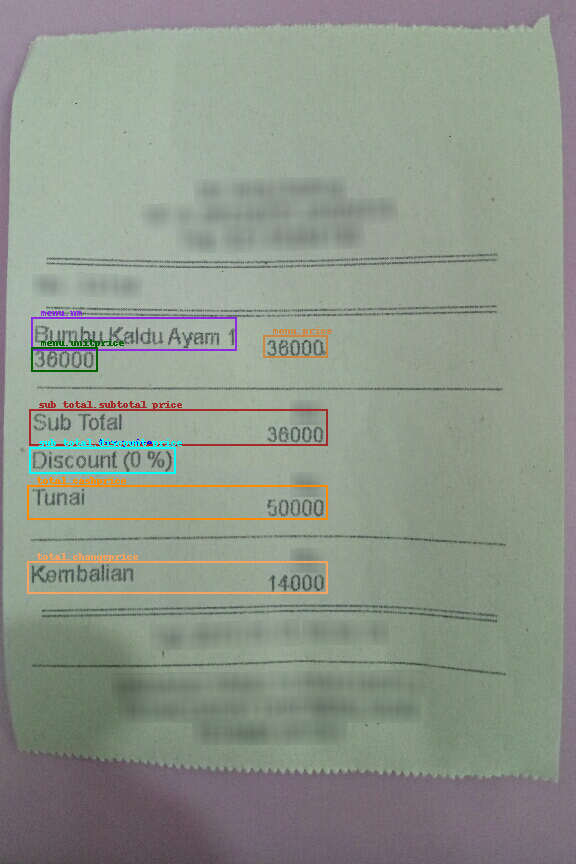

In [85]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image